# Training the model on images

## Imports

In [1]:
# load custom scripts
from dataset import Dataset
from utils import *
import config 

# import the necessary packages
from albumentations.pytorch import ToTensorV2
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
from utils import EarlyStopping
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import segmentation_models_pytorch as smp
import time
import torch
import torchmetrics
import os

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Setup CUDA

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [4]:
# load the image and label filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/small/images")))
labelPaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/small/labels")))

trainImages, testImages, trainLabels, testLabels = train_test_split(imagePaths,
                                                                    labelPaths,
                                                                    test_size=0.2,
                                                                    train_size=0.8,
                                                                    random_state=SEED)
testImages, valImages, testLabels, valLabels = train_test_split(testImages, 
                                                                  testLabels,
                                                                  test_size=0.5,
                                                                  train_size=0.5,
                                                                  random_state=SEED)

# get the masks corresponding to the labels
trainMasks = [s.replace('labels', 'masks_9x9') for s in trainLabels]
valMasks = [s.replace('labels', 'masks_9x9') for s in valLabels]

# save testing images to disk
print("[INFO] saving testing image paths...")
f = open("/data/jantina/CoralNet/dataset/small/output/test_paths.txt", "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## Example

In [5]:
# new label classes
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

In [6]:
a=random.randrange(len(trainImages))
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])

print(f"Image name: {trainImages[a].split('/')[-1]}")
print(f"Image dtype: {image.dtype}, Label dtype: {label.dtype}")

Image name: 2021-11-07-ADELUP-B-T1 9.0-A (PB070428).JPG
Image dtype: uint8, Label dtype: uint8


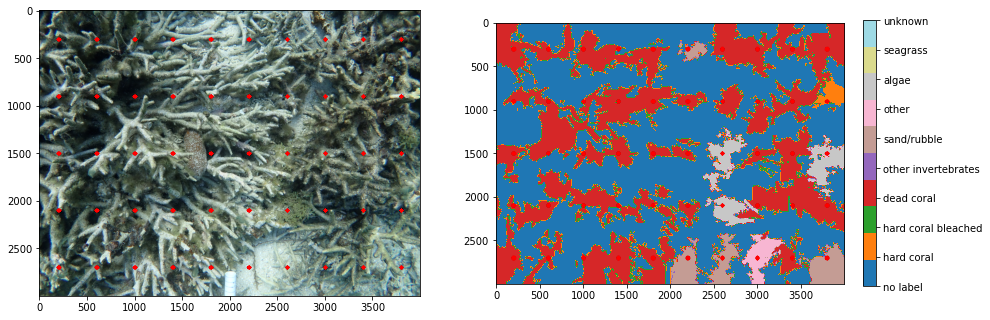

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(image)
ax[0].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cax = ax[1].imshow(label, cmap = plt.cm.get_cmap('tab20', 10), vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Transforms

In [8]:
train_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), 
                        interpolation=cv2.INTER_NEAREST),    
    A.HorizontalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

In [9]:
val_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), 
                        interpolation=cv2.INTER_NEAREST),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

## Example Transforms

In [10]:
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])
transformed = train_transform(image=image, mask=label, mask2=mask)
image = transformed["image"]
label = transformed["mask"]
mask = transformed["mask2"]
            
# convert label and mask to long tensor
label = label.type(torch.LongTensor)
mask = mask.type(torch.LongTensor)

/tmp/ipykernel_169888/1473477371.py:10: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



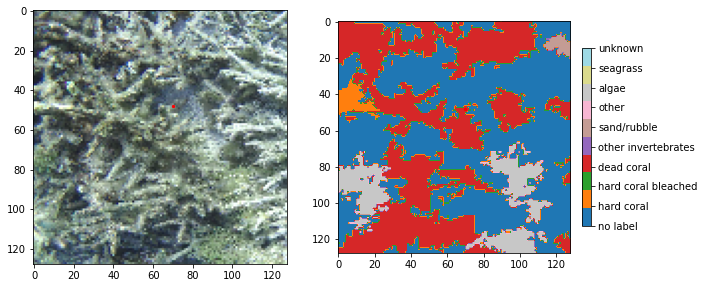

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
ax[0].imshow(unnormalize(image).permute(1, 2, 0))
ax[0].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

ax[1].imshow(label,
             cmap = plt.cm.get_cmap('tab20', 10), 
             vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Create dataset

In [12]:
# create the train and validation datasets
startTime = time.time()
trainDS = Dataset(imagePaths=trainImages, labelPaths = trainLabels, maskPaths=trainMasks, transform=train_transform)
valDS = Dataset(imagePaths=valImages, labelPaths = valLabels, maskPaths=valMasks, transform=val_transform)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(valDS)} examples in the validation set")
print(f"[INFO] found {len(testImages)} examples in the test set")
endTime = time.time()
print("[INFO] total time taken to load the data: {:.2f}s".format(endTime - startTime))

[INFO] found 712 examples in the training set
[INFO] found 89 examples in the validation set
[INFO] found 89 examples in the test set
[INFO] total time taken to load the data: 0.00s


In [13]:
sample = valDS[0]
print(f"Feature shape: {sample[0].shape}, Feature type: {sample[0].dtype}")
print(f"Label shape: {sample[1].shape}, Label type: {sample[1].dtype}")
print(f"Mask shape: {sample[2].shape}, Mask type: {sample[2].dtype}")

Feature shape: torch.Size([3, 128, 128]), Feature type: torch.float32
Label shape: torch.Size([128, 128]), Label type: torch.int64
Mask shape: torch.Size([128, 128]), Mask type: torch.int64


In [14]:
config.BATCH_SIZE = 89

In [15]:
# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count(),
                         persistent_workers=True,
                         worker_init_fn=seed_worker)

valLoader = DataLoader(valDS, shuffle=False, 
                       batch_size=config.BATCH_SIZE, 
                       pin_memory=config.PIN_MEMORY, 
                       num_workers=os.cpu_count(),
                       persistent_workers=True,
                       worker_init_fn=seed_worker)

In [16]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:89
[INFO] num_workers:32


## Model initialization

In [17]:
# import a pretrained model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=len(classes)
)

In [18]:
# initialize model
unet = model.to(config.DEVICE)

# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=0)

config.INIT_LR = 10*(1e-4 * config.BATCH_SIZE / 10)

# initialize optimizer
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(valDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}

In [19]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)

# move the metrics to device
acc.to(config.DEVICE)

# initialize a dictionary to store metrics history
metrics = {"train_accuracyGT": [], "val_accuracyGT": [],
          "train_accuracyAGT": [], "val_accuracyAGT": []}

In [20]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True, 
                               path="/data/jantina/CoralNet/dataset/small/output/checkpoint.pt")

In [21]:
#initialize scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, "min", patience=4, verbose=1)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

## Training loop

In [22]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    #fix seed
    seed_all(SEED)
    
    ###################
    # train the model #
    ###################
    unet.train() # prep model for training

    # initialize the total training and validation loss
    totalTrainLoss, totalValLoss = 0, 0
    
    # initialize the accuracy
    accTrainGT = 0
    accTrainAGT = 0
    accTrainAGT2 = 0
    accValGT = 0
    accValAGT = 0
    accValAGT2 = 0
    countTrainGT = 0
    countTrainAGT = 0
    countValGT = 0
    countValAGT = 0
    
    # loop over the training set
    for batch, (data, target, mask) in enumerate(trainLoader, 1):
        #fix seed
        seed_all(SEED)
        
        # send the input to the device
        (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
        # perform a forward pass 
        pred = unet(data)

        # calculate the training loss
        loss = lossFunc(pred, target)
        
        # for each input
        for i in range(len(target)):
            if torch.sum(mask[i])!=0: # GT and AGT
                # update the accuracy count
                countTrainGT = countTrainGT + 1
                countTrainAGT = countTrainAGT + 1
                # extract the GT label positions in the prediction
                pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                # extract the GT label positions in the target
                pixel_targGT = torch.mul(mask[i], target[i])
                # metrics on current element
                accTrainGT += acc(pixel_predGT, pixel_targGT).item()
                
                # extract the AGT label positions in the prediction
                pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                # extract the AGT label positions in the target
                pixel_targAGT = target[i]-pixel_targGT
                # metrics on current element
                accTrainAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                accTrainAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                
            else: # only AGT
                # update the accuracy count
                countTrainAGT = countTrainAGT + 1
                # metrics on current element
                accTrainAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
                accTrainAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                                
        # Gradient descent with optimizer:
        opt.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(opt)
        grad_scaler.update()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # switch off autograd
    with torch.no_grad():        
        unet.eval() # prep model for evaluation
        
        # loop over the validation set
        for data, target, mask in valLoader:
            #fix seed
            seed_all(SEED)
            
            # send the input to the device
            (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
            # make the predictions 
            pred = unet(data)
            
            # calculate the validation loss
            totalValLoss += lossFunc(pred, target).item()
            
            # scheduler step
            scheduler.step(lossFunc(pred, target))
            
            # for each input
            for i in range(len(target)):
                if torch.sum(mask[i])!=0: # GT and AGT
                    # update the accuracy count
                    countValGT = countValGT + 1
                    countValAGT = countValAGT + 1
                    # extract the GT label positions in the prediction
                    pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                    # extract the GT label positions in the target
                    pixel_targGT = torch.mul(mask[i], target[i])
                    # metrics on current element
                    accValGT += acc(pixel_predGT, pixel_targGT).item()

                    # extract the AGT label positions in the prediction
                    pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                    # extract the AGT label positions in the target
                    pixel_targAGT = target[i]-pixel_targGT
                    # metrics on current element
                    accValAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                    accValAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                    
                    '''                                    
                    # show the validation results
                    fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
                    ax[0].imshow(unnormalize(data[i]).cpu().detach().permute(1, 2, 0))
                    ax[0].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')

                    ax[1].imshow(target[i].cpu(),
                                 cmap = plt.cm.get_cmap('tab20', 10), 
                                 vmin=0, vmax=9)
                    ax[1].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')



                    cax = ax[2].imshow(torch.argmax(pred[i],dim=0).cpu(),
                                       cmap = plt.cm.get_cmap('tab20', 10),
                                       vmin=0, vmax=9)


                    cax = ax[2].imshow(torch.softmax(pred[i],dim=1)[3].cpu())
                    
                    ax[2].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')

                    cbar = fig.colorbar(cax, fraction=0.035)
                    #cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
                    #cbar.ax.set_yticklabels(list(classes.values()))
                    plt.show()
                    '''
                    
                else: # only AGT
                    # update the accuracy count
                    countValAGT = countValAGT + 1
                    # metrics on current element
                    accValAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
                    accValAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValLoss)
    
    # calculate the average metrics
    avgaccTrainGT = accTrainGT / countTrainGT
    avgaccTrainAGT = accTrainAGT / countTrainAGT
    avgaccValGT = accValGT / countValGT
    avgaccValAGT = accValAGT / countValAGT 
    avgaccTrainAGT2 = accTrainAGT2 / countTrainAGT
    avgaccValAGT2 = accValAGT2 / countValAGT
    
    # update our metrics history
    metrics["train_accuracyGT"].append(avgaccTrainGT)
    metrics["val_accuracyGT"].append(avgaccValGT)
    metrics["train_accuracyAGT"].append(avgaccTrainAGT)
    metrics["val_accuracyAGT"].append(avgaccValAGT)
    
    # check early stopping
    early_stopping(avgValLoss, unet)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
    # print the model metrics information
    print("GT Train Accuracy: {:.4f}".format(avgaccTrainGT))
    print("AGT Train Accuracy: {:.4f}".format(avgaccTrainAGT))
    print("AGT 2 Train Accuracy: {:.4f}".format(avgaccTrainAGT2))
    print("GT Val Accuracy: {:.4f}".format(avgaccValGT))
    print("AGT Val Accuracy: {:.4f}".format(avgaccValAGT))
    print("AGT 2 Val Accuracy: {:.4f}".format(avgaccValAGT2))
    
# load the last checkpoint with the best model
unet.load_state_dict(torch.load("/data/jantina/CoralNet/dataset/small/output/checkpoint.pt"))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  1%|█▎                                                                                                                             | 1/100 [00:44<1:12:41, 44.05s/it]

Validation loss decreased (inf --> 160978.578125).  Saving model ...
[INFO] EPOCH: 1/100
Train loss: 1.764382, Validation loss: 160978.5781
GT Train Accuracy: 0.3552
AGT Train Accuracy: 0.4236
AGT 2 Train Accuracy: 0.3457
GT Val Accuracy: 0.2354
AGT Val Accuracy: 0.1396
AGT 2 Val Accuracy: 0.1393


  2%|██▌                                                                                                                            | 2/100 [01:24<1:08:19, 41.83s/it]

Validation loss decreased (160978.578125 --> 315.013672).  Saving model ...
[INFO] EPOCH: 2/100
Train loss: 1.423596, Validation loss: 315.0137
GT Train Accuracy: 0.4647
AGT Train Accuracy: 0.4607
AGT 2 Train Accuracy: 0.4604
GT Val Accuracy: 0.1093
AGT Val Accuracy: 0.1484
AGT 2 Val Accuracy: 0.1481


  3%|███▊                                                                                                                           | 3/100 [02:04<1:06:36, 41.21s/it]

Validation loss decreased (315.013672 --> 56.355850).  Saving model ...
[INFO] EPOCH: 3/100
Train loss: 1.378511, Validation loss: 56.3559
GT Train Accuracy: 0.4501
AGT Train Accuracy: 0.4565
AGT 2 Train Accuracy: 0.4563
GT Val Accuracy: 0.1389
AGT Val Accuracy: 0.1967
AGT 2 Val Accuracy: 0.1965


  4%|█████                                                                                                                          | 4/100 [02:45<1:05:24, 40.88s/it]

Validation loss decreased (56.355850 --> 2.286181).  Saving model ...
[INFO] EPOCH: 4/100
Train loss: 1.349991, Validation loss: 2.2862
GT Train Accuracy: 0.4599
AGT Train Accuracy: 0.4757
AGT 2 Train Accuracy: 0.4755
GT Val Accuracy: 0.4564
AGT Val Accuracy: 0.4631
AGT 2 Val Accuracy: 0.4630


  5%|██████▎                                                                                                                        | 5/100 [03:26<1:04:44, 40.89s/it]

Validation loss decreased (2.286181 --> 1.973401).  Saving model ...
[INFO] EPOCH: 5/100
Train loss: 1.364941, Validation loss: 1.9734
GT Train Accuracy: 0.4796
AGT Train Accuracy: 0.4660
AGT 2 Train Accuracy: 0.4658
GT Val Accuracy: 0.5494
AGT Val Accuracy: 0.4971
AGT 2 Val Accuracy: 0.4968


  6%|███████▌                                                                                                                       | 6/100 [04:06<1:03:55, 40.80s/it]

Validation loss decreased (1.973401 --> 1.266010).  Saving model ...
[INFO] EPOCH: 6/100
Train loss: 1.353175, Validation loss: 1.2660
GT Train Accuracy: 0.4725
AGT Train Accuracy: 0.4669
AGT 2 Train Accuracy: 0.4667
GT Val Accuracy: 0.4669
AGT Val Accuracy: 0.5178
AGT 2 Val Accuracy: 0.5175


  7%|████████▉                                                                                                                      | 7/100 [04:47<1:03:21, 40.88s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 7/100
Train loss: 1.333960, Validation loss: 1.3622
GT Train Accuracy: 0.4938
AGT Train Accuracy: 0.4755
AGT 2 Train Accuracy: 0.4752
GT Val Accuracy: 0.4414
AGT Val Accuracy: 0.4964
AGT 2 Val Accuracy: 0.4962


  8%|██████████▏                                                                                                                    | 8/100 [05:28<1:02:38, 40.85s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 8/100
Train loss: 1.327224, Validation loss: 1.3117
GT Train Accuracy: 0.4759
AGT Train Accuracy: 0.4792
AGT 2 Train Accuracy: 0.4789
GT Val Accuracy: 0.4496
AGT Val Accuracy: 0.4846
AGT 2 Val Accuracy: 0.4843


  9%|███████████▍                                                                                                                   | 9/100 [06:09<1:01:53, 40.81s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 9/100
Train loss: 1.330460, Validation loss: 1.3619
GT Train Accuracy: 0.4962
AGT Train Accuracy: 0.4763
AGT 2 Train Accuracy: 0.4761
GT Val Accuracy: 0.4872
AGT Val Accuracy: 0.4894
AGT 2 Val Accuracy: 0.4891


 10%|████████████▌                                                                                                                 | 10/100 [06:49<1:01:07, 40.75s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 10/100
Train loss: 1.306838, Validation loss: 1.4482
GT Train Accuracy: 0.4944
AGT Train Accuracy: 0.4822
AGT 2 Train Accuracy: 0.4819
GT Val Accuracy: 0.4888
AGT Val Accuracy: 0.4413
AGT 2 Val Accuracy: 0.4410
Epoch    11: reducing learning rate of group 0 to 8.9000e-04.


 11%|█████████████▊                                                                                                                | 11/100 [07:30<1:00:31, 40.80s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 11/100
Train loss: 1.306556, Validation loss: 1.3714
GT Train Accuracy: 0.4730
AGT Train Accuracy: 0.4897
AGT 2 Train Accuracy: 0.4895
GT Val Accuracy: 0.4694
AGT Val Accuracy: 0.4335
AGT 2 Val Accuracy: 0.4331


 12%|███████████████▎                                                                                                                | 12/100 [08:11<59:46, 40.76s/it]

Validation loss decreased (1.266010 --> 1.243961).  Saving model ...
[INFO] EPOCH: 12/100
Train loss: 1.303301, Validation loss: 1.2440
GT Train Accuracy: 0.4897
AGT Train Accuracy: 0.4868
AGT 2 Train Accuracy: 0.4866
GT Val Accuracy: 0.5429
AGT Val Accuracy: 0.5170
AGT 2 Val Accuracy: 0.5167


 13%|████████████████▋                                                                                                               | 13/100 [08:52<59:10, 40.81s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 13/100
Train loss: 1.308576, Validation loss: 1.2975
GT Train Accuracy: 0.4897
AGT Train Accuracy: 0.4842
AGT 2 Train Accuracy: 0.4840
GT Val Accuracy: 0.4724
AGT Val Accuracy: 0.4980
AGT 2 Val Accuracy: 0.4978


 14%|█████████████████▉                                                                                                              | 14/100 [09:32<58:15, 40.65s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 14/100
Train loss: 1.303101, Validation loss: 1.3110
GT Train Accuracy: 0.4811
AGT Train Accuracy: 0.4887
AGT 2 Train Accuracy: 0.4885
GT Val Accuracy: 0.4620
AGT Val Accuracy: 0.4956
AGT 2 Val Accuracy: 0.4953


 15%|███████████████████▏                                                                                                            | 15/100 [10:13<57:32, 40.62s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 15/100
Train loss: 1.284378, Validation loss: 1.2785
GT Train Accuracy: 0.4756
AGT Train Accuracy: 0.4918
AGT 2 Train Accuracy: 0.4915
GT Val Accuracy: 0.5154
AGT Val Accuracy: 0.5027
AGT 2 Val Accuracy: 0.5024


 16%|████████████████████▍                                                                                                           | 16/100 [10:53<56:47, 40.57s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 16/100
Train loss: 1.275794, Validation loss: 1.2859
GT Train Accuracy: 0.4805
AGT Train Accuracy: 0.4949
AGT 2 Train Accuracy: 0.4947
GT Val Accuracy: 0.5331
AGT Val Accuracy: 0.5153
AGT 2 Val Accuracy: 0.5150


 17%|█████████████████████▊                                                                                                          | 17/100 [11:34<56:04, 40.54s/it]

Validation loss decreased (1.243961 --> 1.231130).  Saving model ...
[INFO] EPOCH: 17/100
Train loss: 1.274431, Validation loss: 1.2311
GT Train Accuracy: 0.5038
AGT Train Accuracy: 0.5016
AGT 2 Train Accuracy: 0.5013
GT Val Accuracy: 0.5827
AGT Val Accuracy: 0.5352
AGT 2 Val Accuracy: 0.5349


 18%|███████████████████████                                                                                                         | 18/100 [12:14<55:27, 40.58s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 18/100
Train loss: 1.278857, Validation loss: 1.2608
GT Train Accuracy: 0.4739
AGT Train Accuracy: 0.4963
AGT 2 Train Accuracy: 0.4960
GT Val Accuracy: 0.6073
AGT Val Accuracy: 0.4998
AGT 2 Val Accuracy: 0.4996


 19%|████████████████████████▎                                                                                                       | 19/100 [12:54<54:32, 40.40s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 19/100
Train loss: 1.258789, Validation loss: 1.2698
GT Train Accuracy: 0.5066
AGT Train Accuracy: 0.5072
AGT 2 Train Accuracy: 0.5070
GT Val Accuracy: 0.4302
AGT Val Accuracy: 0.5105
AGT 2 Val Accuracy: 0.5103


 20%|█████████████████████████▌                                                                                                      | 20/100 [13:34<53:33, 40.17s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 20/100
Train loss: 1.273176, Validation loss: 1.2888
GT Train Accuracy: 0.4986
AGT Train Accuracy: 0.5089
AGT 2 Train Accuracy: 0.5086
GT Val Accuracy: 0.5134
AGT Val Accuracy: 0.4909
AGT 2 Val Accuracy: 0.4906


 21%|██████████████████████████▉                                                                                                     | 21/100 [14:14<52:49, 40.12s/it]

Validation loss decreased (1.231130 --> 1.211513).  Saving model ...
[INFO] EPOCH: 21/100
Train loss: 1.255140, Validation loss: 1.2115
GT Train Accuracy: 0.5045
AGT Train Accuracy: 0.5101
AGT 2 Train Accuracy: 0.5098
GT Val Accuracy: 0.5063
AGT Val Accuracy: 0.5208
AGT 2 Val Accuracy: 0.5205


 22%|████████████████████████████▏                                                                                                   | 22/100 [14:54<52:01, 40.02s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 22/100
Train loss: 1.257066, Validation loss: 1.2733
GT Train Accuracy: 0.5167
AGT Train Accuracy: 0.5090
AGT 2 Train Accuracy: 0.5088
GT Val Accuracy: 0.4870
AGT Val Accuracy: 0.5044
AGT 2 Val Accuracy: 0.5042


 23%|█████████████████████████████▍                                                                                                  | 23/100 [15:34<51:22, 40.03s/it]

Validation loss decreased (1.211513 --> 1.173259).  Saving model ...
[INFO] EPOCH: 23/100
Train loss: 1.261927, Validation loss: 1.1733
GT Train Accuracy: 0.5114
AGT Train Accuracy: 0.5088
AGT 2 Train Accuracy: 0.5085
GT Val Accuracy: 0.3791
AGT Val Accuracy: 0.5369
AGT 2 Val Accuracy: 0.5367


 24%|██████████████████████████████▋                                                                                                 | 24/100 [16:13<50:31, 39.89s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 24/100
Train loss: 1.258895, Validation loss: 1.2838
GT Train Accuracy: 0.5281
AGT Train Accuracy: 0.5124
AGT 2 Train Accuracy: 0.5122
GT Val Accuracy: 0.4068
AGT Val Accuracy: 0.4912
AGT 2 Val Accuracy: 0.4910


 25%|████████████████████████████████                                                                                                | 25/100 [16:54<49:58, 39.98s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 25/100
Train loss: 1.245587, Validation loss: 1.2446
GT Train Accuracy: 0.4934
AGT Train Accuracy: 0.5160
AGT 2 Train Accuracy: 0.5158
GT Val Accuracy: 0.4406
AGT Val Accuracy: 0.5106
AGT 2 Val Accuracy: 0.5104


 26%|█████████████████████████████████▎                                                                                              | 26/100 [17:33<49:13, 39.92s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 26/100
Train loss: 1.250820, Validation loss: 1.2207
GT Train Accuracy: 0.5241
AGT Train Accuracy: 0.5130
AGT 2 Train Accuracy: 0.5128
GT Val Accuracy: 0.4823
AGT Val Accuracy: 0.5194
AGT 2 Val Accuracy: 0.5192


 27%|██████████████████████████████████▌                                                                                             | 27/100 [18:13<48:31, 39.89s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 27/100
Train loss: 1.259164, Validation loss: 1.2322
GT Train Accuracy: 0.5189
AGT Train Accuracy: 0.5079
AGT 2 Train Accuracy: 0.5077
GT Val Accuracy: 0.5382
AGT Val Accuracy: 0.5069
AGT 2 Val Accuracy: 0.5066


 28%|███████████████████████████████████▊                                                                                            | 28/100 [18:52<47:41, 39.74s/it]

Epoch    28: reducing learning rate of group 0 to 8.9000e-05.
EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 28/100
Train loss: 1.249268, Validation loss: 1.2456
GT Train Accuracy: 0.5069
AGT Train Accuracy: 0.5113
AGT 2 Train Accuracy: 0.5111
GT Val Accuracy: 0.5300
AGT Val Accuracy: 0.5183
AGT 2 Val Accuracy: 0.5180


 29%|█████████████████████████████████████                                                                                           | 29/100 [19:32<47:05, 39.79s/it]

EarlyStopping counter: 6 out of 10
[INFO] EPOCH: 29/100
Train loss: 1.241107, Validation loss: 1.2200
GT Train Accuracy: 0.5035
AGT Train Accuracy: 0.5145
AGT 2 Train Accuracy: 0.5143
GT Val Accuracy: 0.5303
AGT Val Accuracy: 0.5233
AGT 2 Val Accuracy: 0.5231


 30%|██████████████████████████████████████▍                                                                                         | 30/100 [20:12<46:26, 39.80s/it]

EarlyStopping counter: 7 out of 10
[INFO] EPOCH: 30/100
Train loss: 1.245531, Validation loss: 1.1987
GT Train Accuracy: 0.5084
AGT Train Accuracy: 0.5201
AGT 2 Train Accuracy: 0.5199
GT Val Accuracy: 0.5575
AGT Val Accuracy: 0.5300
AGT 2 Val Accuracy: 0.5298


 31%|███████████████████████████████████████▋                                                                                        | 31/100 [20:52<45:49, 39.84s/it]

EarlyStopping counter: 8 out of 10
[INFO] EPOCH: 31/100
Train loss: 1.254892, Validation loss: 1.2530
GT Train Accuracy: 0.5092
AGT Train Accuracy: 0.5107
AGT 2 Train Accuracy: 0.5105
GT Val Accuracy: 0.5211
AGT Val Accuracy: 0.5134
AGT 2 Val Accuracy: 0.5132


 32%|████████████████████████████████████████▉                                                                                       | 32/100 [21:32<45:07, 39.81s/it]

EarlyStopping counter: 9 out of 10
[INFO] EPOCH: 32/100
Train loss: 1.244549, Validation loss: 1.1961
GT Train Accuracy: 0.5205
AGT Train Accuracy: 0.5167
AGT 2 Train Accuracy: 0.5165
GT Val Accuracy: 0.5849
AGT Val Accuracy: 0.5413
AGT 2 Val Accuracy: 0.5411


 32%|████████████████████████████████████████▉                                                                                       | 32/100 [22:12<47:11, 41.65s/it]

Epoch    33: reducing learning rate of group 0 to 8.9000e-06.
EarlyStopping counter: 10 out of 10
Early stopping
[INFO] total time taken to train the model: 1332.69s


## Plotting the loss

In [26]:
H = pd.DataFrame(H)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=H.index, y=H['train_loss'],
                    mode='lines',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=H.index, y=H['validation_loss'],
                    mode='lines',
                    name='Validation Loss'))

fig.update_layout(title='Training and Testing Loss on Dataset',
                   xaxis_title='Epoch #',
                   yaxis_title='Loss')

fig.update_xaxes(range = [-1,33])
fig.update_yaxes(range = [0,4])

fig.show()

## Plotting the metrics

In [27]:
metrics = pd.DataFrame(metrics)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyAGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyAGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))

fig.update_layout(title='Metrics',
                   xaxis_title='Epoch #',
                   yaxis_title='Accuracy')

fig.update_xaxes(range = [-1,33])
fig.update_yaxes(range = [0,1])

fig.show()

# Save model

In [25]:
# serialize the model to disk
torch.save(unet, "/data/jantina/CoralNet/dataset/small/output/unet.pth")
print("[INFO] model saved !")

[INFO] model saved !
